In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC


In [34]:

import warnings
warnings.filterwarnings("ignore")

In [35]:

df = pd.read_csv("touch.csv")

In [36]:
columns_to_remove = ['touch', 'finger', 'palm', 'fist']
df = df.drop(columns=columns_to_remove, errors='ignore')

I removed touch finger palm and fist

In [37]:
sensor_columns = [str(i) for i in range(1, 3201)]

In [38]:
zero_count_threshold = 300
zero_counts = (df[sensor_columns] == 0).sum(axis=0)
columns_to_drop_zero = zero_counts[zero_counts > zero_count_threshold].index
df = df.drop(columns=columns_to_drop_zero)
print(f"\n{len(columns_to_drop_zero)} adet çok fazla 0 içeren sütun kaldırıldı (>{zero_count_threshold} tane 0 içeren).")


56 adet çok fazla 0 içeren sütun kaldırıldı (>300 tane 0 içeren).


To improve data quality and reduce noise, I removed sensor columns that contain an excessive number of zero values. These are often uninformative or may represent inactive or faulty sensors.

In [39]:

original_count = len(sensor_columns)
sensor_columns = [col for col in sensor_columns if col in df.columns]
new_count = len(sensor_columns)
print(f"   Listeden çıkarılan isim sayısı: {original_count - new_count}") 
print(f"   Listede kalan sensör sütunu sayısı: {new_count}") 

   Listeden çıkarılan isim sayısı: 56
   Listede kalan sensör sütunu sayısı: 3144


After removing sensor columns with too many zeros, I updated the list of sensor column names to reflect the changes in the dataframe.

In [40]:

z_score_threshold = 4
columns_found_with_outliers = set()
valid_sensor_columns_for_check = [col for col in sensor_columns if col in df.columns]
print(f"Aykırı değer kontrolü yapılacak sütun sayısı: {len(valid_sensor_columns_for_check)}")
for col in valid_sensor_columns_for_check:
    col_data = df[col].dropna()
    if len(col_data) < 2 or col_data.std() == 0 or pd.isna(col_data.std()):
        continue
    z_scores = np.abs((col_data - col_data.mean()) / col_data.std())
    if (z_scores > z_score_threshold).any():
        columns_found_with_outliers.add(col)
if columns_found_with_outliers:
    original_sensor_count = len(sensor_columns)
    original_df_cols = df.shape[1]
    cols_to_drop_list = list(columns_found_with_outliers)
    df = df.drop(columns=cols_to_drop_list, errors='ignore')
    print(f"{original_df_cols - df.shape[1]} adet sütun DataFrame'den kaldırıldı.")
    print(f"İşlem sonrası DataFrame şekli: {df.shape}")
    sensor_columns = [col for col in sensor_columns if col not in columns_found_with_outliers]
    removed_count = original_sensor_count - len(sensor_columns)
    print(f"İşlem sonrası 'sensor_columns' listesindeki sütun sayısı: {len(sensor_columns)}")
else:
    print("\nBelirtilen eşiğe göre aykırı değer içeren sütun bulunamadı.")
    print(f"'df' ve 'sensor_columns' listesi bu adımda değişmedi.")

Aykırı değer kontrolü yapılacak sütun sayısı: 3144
168 adet sütun DataFrame'den kaldırıldı.
İşlem sonrası DataFrame şekli: (2056, 2978)
İşlem sonrası 'sensor_columns' listesindeki sütun sayısı: 2976


In this step, I scanned the sensor columns for extreme outliers using the Z-score method. If a column contained any values with a Z-score higher than a specified threshold, I considered it unreliable and removed it from the dataset.

In [41]:

sensor_columns = [col for col in sensor_columns if col in df.columns]
variance_threshold = 300
variances = df[sensor_columns].var(axis=0)
columns_to_drop_variance = variances[variances < variance_threshold].index.tolist()
df = df.drop(columns=columns_to_drop_variance)
sensor_columns = [col for col in sensor_columns if col not in columns_to_drop_variance]
print(f"{len(columns_to_drop_variance)} adet düşük varyanslı sütun kaldırıldı.")


285 adet düşük varyanslı sütun kaldırıldı.


In this step, I removed sensor columns that exhibit very little variance. Such features are unlikely to be informative for modeling, since they don’t show much change or differentiation across samples.

In [42]:

X_user = df[sensor_columns]
y_user = df['user_id']
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X_user, y_user, test_size=0.3, random_state=13, stratify=y_user
)

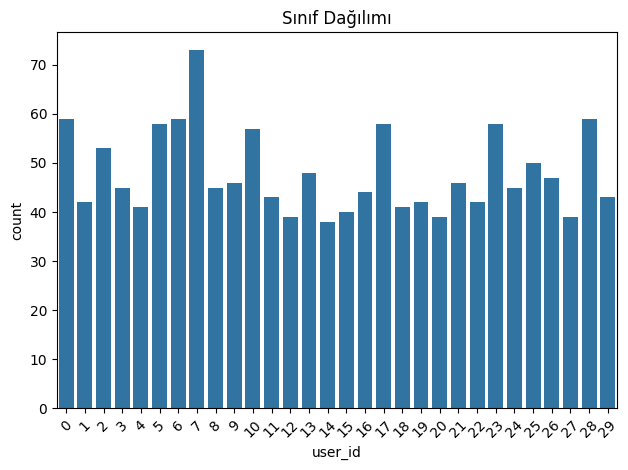

In [43]:
sns.countplot(x=y_train_user)
plt.title("Sınıf Dağılımı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To understand how balanced the target classes are in the training set, I plotted a count plot using Seaborn

In [44]:

preprocessor_user = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('feature_selection', SelectKBest(score_func=f_classif, k=200))
])

 To prepare the feature data for training, I created a preprocessing pipeline using sklearn.Pipeline. This ensures that scaling and feature selection are applied consistently and in the correct order.

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

pipeline_user_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_user),  
    ('classifier', XGBClassifier(
        random_state=13,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        use_label_encoder=False
    ))
])
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
n_splits = 5
scores_user_xgb = cross_val_score(pipeline_user_xgb, X_train_user, y_train_user, 
                                cv=cv_splitter, scoring='accuracy', n_jobs=-1)
print(f"\nXGBoost {n_splits}-Katlı Çapraz Doğrulama Doğruluk Skorları (user_id):")
print(scores_user_xgb)
print(f"Ortalama Doğruluk (user_id): {np.mean(scores_user_xgb):.4f}")
print(f"Doğruluk Standart Sapması (user_id): {np.std(scores_user_xgb):.4f}")


XGBoost 5-Katlı Çapraz Doğrulama Doğruluk Skorları (user_id):
[1.         0.98958333 1.         0.99652778 0.98954704]
Ortalama Doğruluk (user_id): 0.9951
Doğruluk Standart Sapması (user_id): 0.0047


I built and evaluated an XGBoost model for user classification using a 5-fold Stratified Cross-Validation approach. The model was integrated into a scikit-learn pipeline to include preprocessing and feature selection steps.


XGBoost ile User ID Tahmini Doğruluk: 1.0000

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        26
           1     1.0000    1.0000    1.0000        18
           2     1.0000    1.0000    1.0000        23
           3     1.0000    1.0000    1.0000        20
           4     1.0000    1.0000    1.0000        18
           5     1.0000    1.0000    1.0000        25
           6     1.0000    1.0000    1.0000        25
           7     1.0000    1.0000    1.0000        31
           8     1.0000    1.0000    1.0000        19
           9     1.0000    1.0000    1.0000        19
          10     1.0000    1.0000    1.0000        24
          11     1.0000    1.0000    1.0000        19
          12     1.0000    1.0000    1.0000        17
          13     1.0000    1.0000    1.0000        21
          14     1.0000    1.0000    1.0000        16
          15     1.0000    1.0000    1.0000        17
    

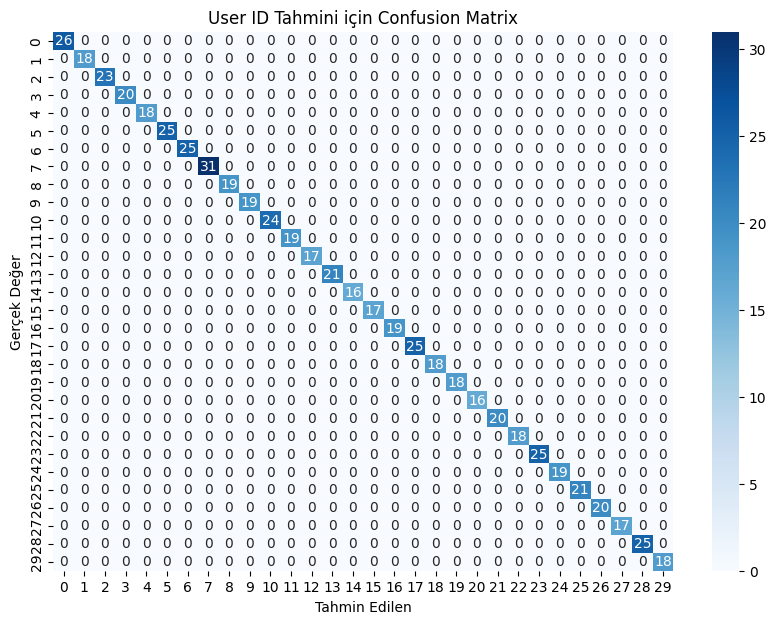

In [15]:
pipeline_user_xgb.fit(X_train_user, y_train_user)
y_pred_user = pipeline_user_xgb.predict(X_test_user)
accuracy_user = accuracy_score(y_test_user, y_pred_user)
print(f"\nXGBoost ile User ID Tahmini Doğruluk: {accuracy_user:.4f}")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test_user, y_pred_user, digits=4))
print("\nConfusion Matrix:")
cm_user = confusion_matrix(y_test_user, y_pred_user)
print(cm_user)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
cv_results = cross_validate(pipeline_user_xgb, X_train_user, y_train_user, cv=5, scoring=scoring)
for metric in scoring:
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")
plt.figure(figsize=(10, 7))
sns.heatmap(cm_user, annot=True, fmt='d', cmap='Blues')
plt.title('User ID Tahmini için Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

After training the XGBoost model with the user data, I evaluated its performance on the test set using various classification metrics, including accuracy, classification report, and confusion matrix. I also performed cross-validation for additional performance insights.




🎯 En Önemli 10 Özellik:
    Feature  Importance
74     1139    0.006971
66      995    0.006953
80     1252    0.006614
4       119    0.006197
41      573    0.006191
151    2669    0.006186
140    2558    0.006167
133    2316    0.006019
105    1772    0.005992
158    2736    0.005978


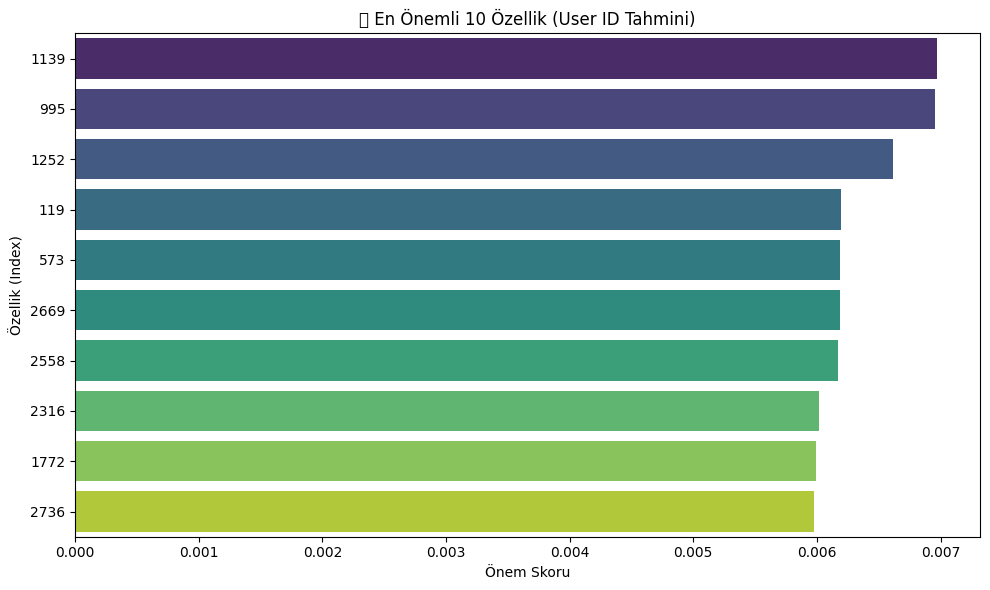

🧪 Şüpheli Yüksek Korelasyonlar:
Series([], dtype: float64)


In [49]:

selected_mask = pipeline_user_xgb.named_steps['preprocessor'].named_steps['feature_selection'].get_support()
selected_features = X_train_user.columns[selected_mask]
importances = pipeline_user_xgb.named_steps['classifier'].feature_importances_
top_features = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)
print("\n🎯 En Önemli 10 Özellik:")
print(top_features.head(10))
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('📈 En Önemli 10 Özellik (User ID Tahmini)')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellik (Index)')
plt.tight_layout()
plt.show()
df['user_id_encoded'] = df['user_id'].astype('category').cat.codes
correlations = df[sensor_columns].corrwith(df['user_id_encoded']).abs()
high_corr = correlations[correlations > 0.9] 
print("🧪 Şüpheli Yüksek Korelasyonlar:")
print(high_corr)

I performed two important analyses:

Feature Importance: I identified the most influential features for predicting user ID.

Correlation Check: I investigated any potential high correlations between features and the target variable (user_id), which could indicate redundancy.

In [48]:
from sklearn.utils import shuffle
df_shuffled = df.copy()
df_shuffled['user_id'] = shuffle(df['user_id'].values, random_state=13)
X_user = df_shuffled[sensor_columns]
y_user = df_shuffled['user_id']
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X_user, y_user, test_size=0.3, random_state=13, stratify=y_user
)
pipeline_user_xgb.fit(X_train_user, y_train_user)
y_pred_user = pipeline_user_xgb.predict(X_test_user)
accuracy_user = accuracy_score(y_test_user, y_pred_user)
print(f"\n🚨 Karıştırılmış etiketlerle doğruluk: {accuracy_user:.4f}")


🚨 Karıştırılmış etiketlerle doğruluk: 0.0340


 I randomly shuffled the user IDs while keeping the features intact.then evaluated the XGBoost model's performance on this shuffled dataset to see how the accuracy drops when the relationship between features and target is disrupted.

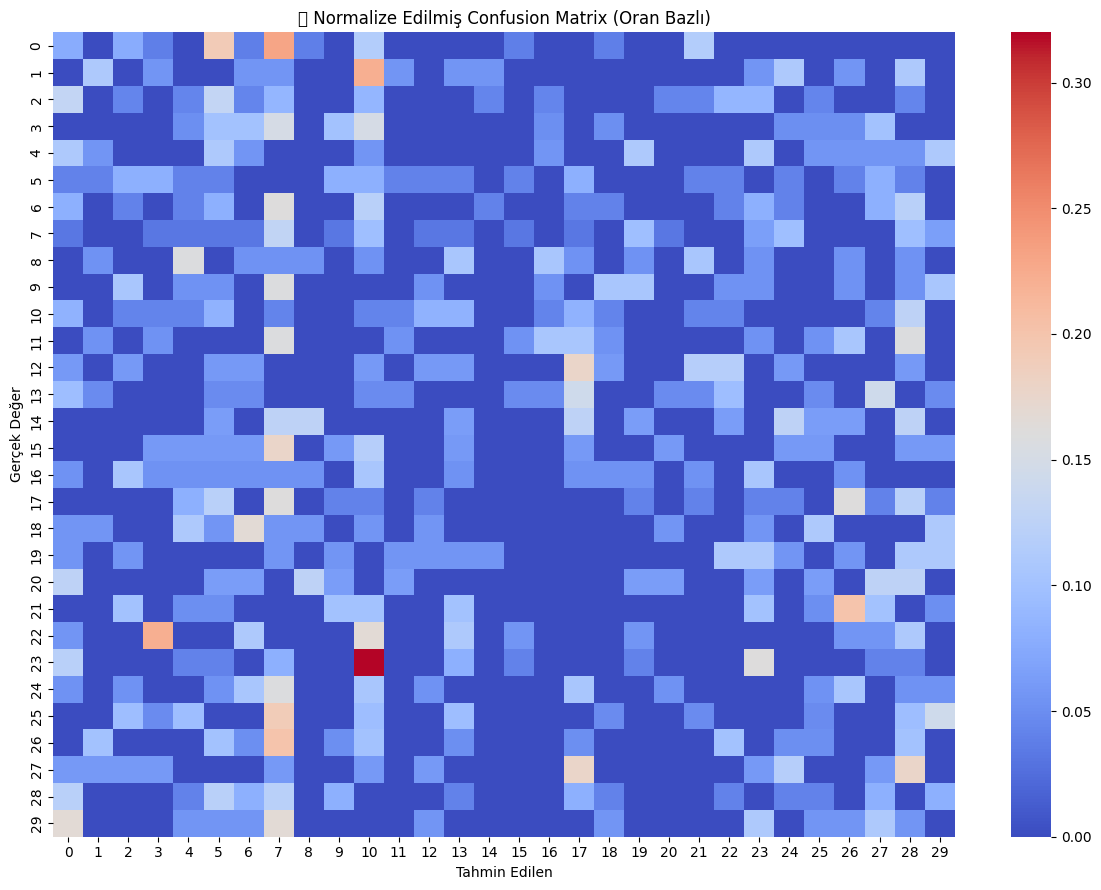

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_norm = confusion_matrix(y_test_user, y_pred_user, normalize='true')
plt.figure(figsize=(12, 9))
sns.heatmap(cm_norm, annot=False, cmap="coolwarm", xticklabels=np.unique(y_test_user), yticklabels=np.unique(y_test_user))
plt.title("🔁 Normalize Edilmiş Confusion Matrix (Oran Bazlı)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.tight_layout()
plt.show()

normalized confusion matrix is a way to visualize how well the model performs in terms of classification accuracy, as it shows the performance across all classes as percentages

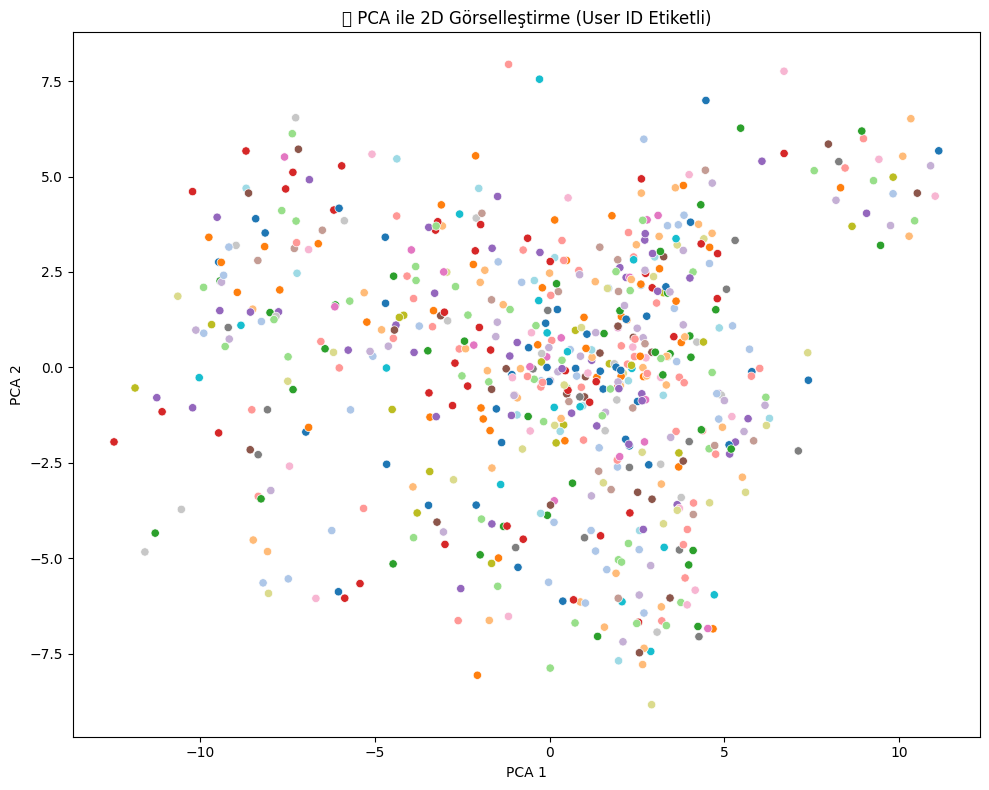

In [19]:
from sklearn.decomposition import PCA
X_transformed = pipeline_user_xgb.named_steps['preprocessor'].transform(X_test_user)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_user, palette='tab20', legend=False)
plt.title("🌐 PCA ile 2D Görselleştirme (User ID Etiketli)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()


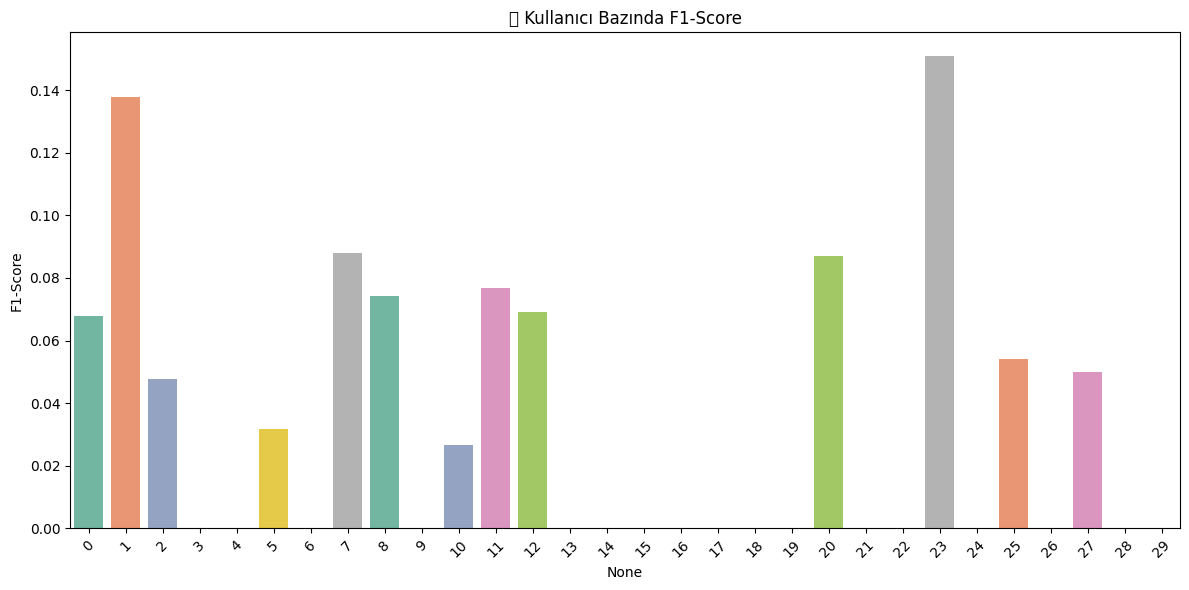

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test_user, y_pred_user, output_dict=True)
f1_scores = pd.DataFrame(report).T.iloc[:-3][['f1-score']]
plt.figure(figsize=(12, 6))
sns.barplot(x=f1_scores.index, y='f1-score', data=f1_scores, palette='Set2')
plt.title('📊 Kullanıcı Bazında F1-Score')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:

X_touch = df[sensor_columns] 
y_touch = df['touch_type']
X_train_touch, X_test_touch, y_train_touch, y_test_touch = train_test_split(
    X_touch, y_touch, test_size=0.3, random_state=13, stratify=y_touch
)

In [22]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
import numpy as np 
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
preprocessor_touch = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('feature_selection', SelectKBest(score_func=f_classif, k=100))
])
pipeline_touch_svm = Pipeline(steps=[
    ('preprocessor', preprocessor_touch),
    ('classifier', SVC(
        C=10,                 
        kernel='rbf',          
        gamma='scale',         
        class_weight='balanced', 
        random_state=13,                                                           
    ))
])
print("SVM pipeline (pipeline_touch_svm) tanımlandı.")

SVM pipeline (pipeline_touch_svm) tanımlandı.


Selects the top 100 features based on the ANOVA  and I’ve set up a Support Vector Machine (SVM) pipeline for classification 

In [23]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


preprocessor_touch = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=300))  
])
pipeline_touch_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_touch),
    ('classifier', XGBClassifier(
        random_state=13,
        n_estimators=100,     
        max_depth=7,         
        learning_rate=0.1,    
        subsample=0.8,        
        colsample_bytree=0.8, 
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    ))
])

print("XGBoost pipeline (pipeline_touch_xgb) tanımlandı.")


XGBoost pipeline (pipeline_touch_xgb) tanımlandı.


I’ve defined an XGBoost (XGBClassifier) pipeline for classification and selects the top 300 features  

In [ ]:
from sklearn.model_selection import GridSearchCV
#BURAYI TEKRAR ÇALIŞTIRMA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! BURAYI TEKRAR ÇALIŞTIRMA !!!!!!!!!!!!! BURAYI TEKRAR ÇALIŞTIRMA !!!!!!!!!!!! BURAYI TEKRAR ÇALIŞTIRMA !!!! ÇOK UZUN SÜRÜYOR
param_grid = {
    'preprocessor__feature_selection__k': [100, 200, 300, 400],
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipeline_touch_svm, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_touch, y_train_touch)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor:", grid_search.best_score_)

En iyi parametreler: {'classifier__C': 10, 'classifier__gamma': 'scale', 'preprocessor__feature_selection__k': 100}
En iyi skor: 0.5702704077832921


grid search for the best parameters

In [24]:

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
print("\n'pipeline_touch_svm' için 5-Katlı Çapraz Doğrulama başlıyor...")
scoring_metric = 'f1_macro' 
scores_touch_svm = cross_val_score(
    pipeline_touch_svm,
    X_train_touch,
    y_train_touch,
    cv=cv_splitter,
    scoring=scoring_metric,
    n_jobs=-1
)
print(f"\n{n_splits}-Katlı Çapraz Doğrulama '{scoring_metric}' Skorları (SVM - touch_type):")
print(scores_touch_svm)
print(f"Ortalama '{scoring_metric}' (SVM - touch_type): {np.mean(scores_touch_svm):.4f}")
print(f"'{scoring_metric}' Standart Sapması (SVM - touch_type): {np.std(scores_touch_svm):.4f}")
print("--------------------------------------------")


'pipeline_touch_svm' için 5-Katlı Çapraz Doğrulama başlıyor...

5-Katlı Çapraz Doğrulama 'f1_macro' Skorları (SVM - touch_type):
[0.56967256 0.61176898 0.55222484 0.54936296 0.59396702]
Ortalama 'f1_macro' (SVM - touch_type): 0.5754
'f1_macro' Standart Sapması (SVM - touch_type): 0.0241
--------------------------------------------


I have initiated the  (5-Fold Cross-Validation) process for the SVM model with Touch Type classification, using F1 Macro as the scoring metric.


SVM modeli (pipeline_touch_svm) eğitiliyor...

Test seti üzerinde tahmin yapılıyor (SVM)...

Touch Type Tahmini için Doğruluk (SVM): 0.7666

Touch Type Sınıflandırma Raporu (SVM):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       343
           1       0.53      0.54      0.53        37
           2       0.42      0.44      0.43        34
           3       0.33      0.48      0.39        27
           4       0.44      0.29      0.35        24
           5       0.64      0.54      0.58        26
           6       0.55      0.61      0.58        28
           7       0.67      0.67      0.67        30
           8       0.89      0.86      0.88        37
           9       0.80      0.65      0.71        31

    accuracy                           0.77       617
   macro avg       0.62      0.60      0.60       617
weighted avg       0.77      0.77      0.77       617


Touch Type Confusion Matrix (SVM) oluşturuluyor...


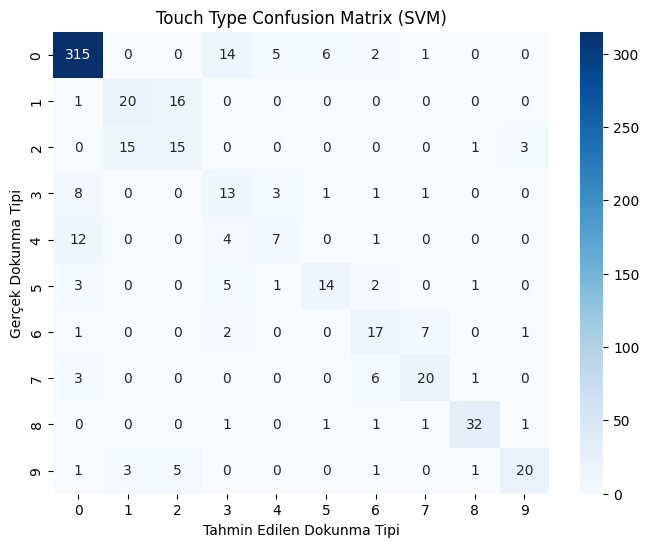

In [25]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print("\nSVM modeli (pipeline_touch_svm) eğitiliyor...")
pipeline_touch_svm.fit(X_train_touch, y_train_touch)
print("\nTest seti üzerinde tahmin yapılıyor (SVM)...")
y_pred_touch_svm = pipeline_touch_svm.predict(X_test_touch)
accuracy_touch_svm = accuracy_score(y_test_touch, y_pred_touch_svm)
print(f"\nTouch Type Tahmini için Doğruluk (SVM): {accuracy_touch_svm:.4f}")
print("\nTouch Type Sınıflandırma Raporu (SVM):")
print(classification_report(y_test_touch, y_pred_touch_svm))
print("\nTouch Type Confusion Matrix (SVM) oluşturuluyor...")
cm_touch_svm = confusion_matrix(y_test_touch, y_pred_touch_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_touch_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_touch), yticklabels=np.unique(y_touch))
plt.xlabel('Tahmin Edilen Dokunma Tipi')
plt.ylabel('Gerçek Dokunma Tipi')
plt.title('Touch Type Confusion Matrix (SVM)')
plt.show()

I have trained the SVM model (pipeline_touch_svm) and made predictions on the test set

🔍 Orijinal sınıf dağılımı:
Counter({0: 801, 1: 86, 8: 86, 2: 78, 9: 72, 7: 69, 6: 64, 3: 63, 5: 62, 4: 58})

🧹 SMOTE + Tomek sonrası sınıf dağılımı:
Counter({0: 801, 2: 801, 5: 801, 1: 801, 3: 801, 6: 801, 9: 801, 4: 801, 8: 801, 7: 801})

🎯 Doğruluk (SMOTE + Tomek): 0.7439

📋 Sınıflandırma Raporu (SMOTE + Tomek):
              precision    recall  f1-score   support

           0     0.8819    0.9359    0.9081       343
           1     0.4615    0.4865    0.4737        37
           2     0.3250    0.3824    0.3514        34
           3     0.2857    0.2963    0.2909        27
           4     0.6000    0.2500    0.3529        24
           5     0.6667    0.5385    0.5957        26
           6     0.5161    0.5714    0.5424        28
           7     0.6667    0.6000    0.6316        30
           8     0.9062    0.7838    0.8406        37
           9     0.6400    0.5161    0.5714        31

    accuracy                         0.7439       617
   macro avg     0.5950    0.5361 

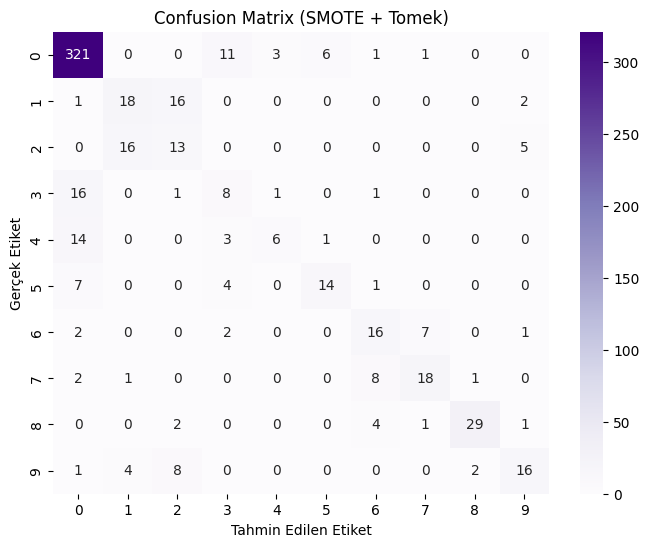

In [26]:
from imblearn.combine import SMOTETomek
from collections import Counter
print("🔍 Orijinal sınıf dağılımı:")
print(Counter(y_train_touch))
smt = SMOTETomek(random_state=13)
X_resampled, y_resampled = smt.fit_resample(X_train_touch, y_train_touch)
print("\n🧹 SMOTE + Tomek sonrası sınıf dağılımı:")
print(Counter(y_resampled))
pipeline_touch_svm.fit(X_resampled, y_resampled)
y_pred_smt = pipeline_touch_svm.predict(X_test_touch)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print(f"\n🎯 Doğruluk (SMOTE + Tomek): {accuracy_score(y_test_touch, y_pred_smt):.4f}")
print("\n📋 Sınıflandırma Raporu (SMOTE + Tomek):")
print(classification_report(y_test_touch, y_pred_smt, digits=4))
cm = confusion_matrix(y_test_touch, y_pred_smt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=np.unique(y_test_touch),
            yticklabels=np.unique(y_test_touch))
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Confusion Matrix (SMOTE + Tomek)")
plt.show()





To deal with class imbalance, we use the SMOTETomek technique
After resampling the data, we train the SVM model using the balanced dataset (X_resampled, y_resampled).
We then evaluate the performance of the model on the test set (X_test_touch, y_test_touch)
We visualize the Confusion Matrix using a heatmap to assess how well the model is classifying each touch type:

🎯 Doğruluk (SMOTE sonrası): 0.7439

📋 Sınıflandırma Raporu (SMOTE sonrası):
              precision    recall  f1-score   support

           0     0.8819    0.9359    0.9081       343
           1     0.4615    0.4865    0.4737        37
           2     0.3250    0.3824    0.3514        34
           3     0.2857    0.2963    0.2909        27
           4     0.6000    0.2500    0.3529        24
           5     0.6667    0.5385    0.5957        26
           6     0.5161    0.5714    0.5424        28
           7     0.6667    0.6000    0.6316        30
           8     0.9062    0.7838    0.8406        37
           9     0.6400    0.5161    0.5714        31

    accuracy                         0.7439       617
   macro avg     0.5950    0.5361    0.5559       617
weighted avg     0.7421    0.7439    0.7386       617



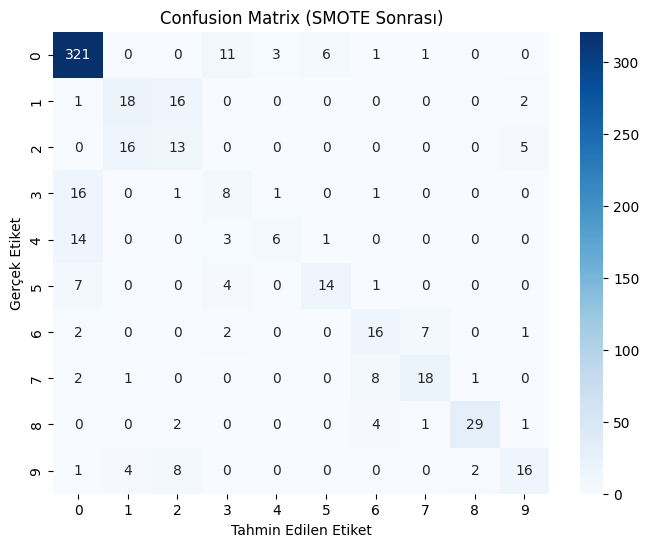

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_smote = pipeline_touch_svm.predict(X_test_touch)
accuracy = accuracy_score(y_test_touch, y_pred_smote)
print(f"🎯 Doğruluk (SMOTE sonrası): {accuracy:.4f}")
print("\n📋 Sınıflandırma Raporu (SMOTE sonrası):")
print(classification_report(y_test_touch, y_pred_smote, digits=4))
cm = confusion_matrix(y_test_touch, y_pred_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_touch),
            yticklabels=np.unique(y_test_touch))
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Confusion Matrix (SMOTE Sonrası)")
plt.show()


We evaluate the accuracy of the model after applying the SMOTE technique, which is designed to handle class imbalance by oversampling the minority class:

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
preprocessor_touch = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=300)) 
])
pipeline_touch_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_touch),
    ('classifier', XGBClassifier(
        random_state=13,
        n_estimators=200,     
        max_depth=7,         
        learning_rate=0.05,    
        subsample=0.8,       
        colsample_bytree=0.8, 
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    ))
])
print("XGBoost pipeline (pipeline_touch_xgb) tanımlandı.")

XGBoost pipeline (pipeline_touch_xgb) tanımlandı.


We define a Pipeline in XGBoost to preprocess the data and classify the Touch Type using the XGBClassifier 

In [29]:
from sklearn.model_selection import cross_val_score

scores_touch_xgb = cross_val_score(
    pipeline_touch_xgb,
    X_train_touch,
    y_train_touch,
    cv=cv_splitter,
    scoring='f1_macro',
    n_jobs=-1
)
print("XGBoost F1 Macro Skorları:", scores_touch_xgb)
print("Ortalama F1:", np.mean(scores_touch_xgb))

XGBoost F1 Macro Skorları: [0.46598015 0.43610235 0.50500828 0.45556726 0.48331114]
Ortalama F1: 0.4691938342715612



XGBoost Doğruluk: 0.7423

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       343
           1       0.54      0.54      0.54        37
           2       0.44      0.41      0.42        34
           3       0.38      0.11      0.17        27
           4       0.00      0.00      0.00        24
           5       0.58      0.54      0.56        26
           6       0.45      0.46      0.46        28
           7       0.64      0.60      0.62        30
           8       0.67      0.70      0.68        37
           9       0.50      0.48      0.49        31

    accuracy                           0.74       617
   macro avg       0.51      0.48      0.49       617
weighted avg       0.69      0.74      0.71       617



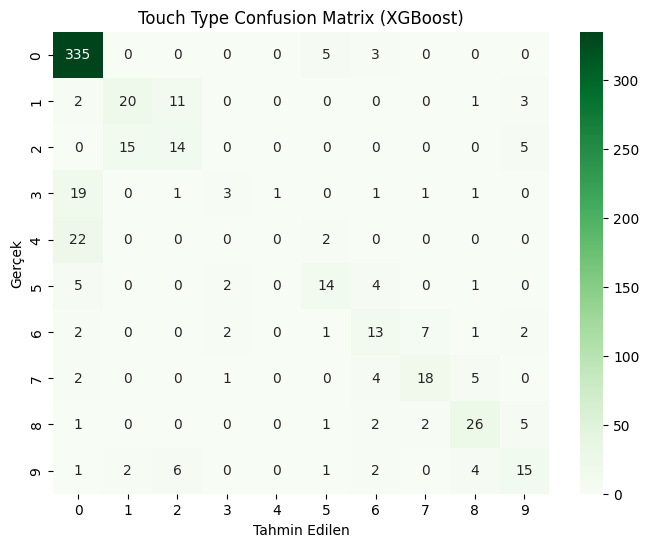

In [30]:
pipeline_touch_xgb.fit(X_train_touch, y_train_touch)
y_pred_touch_xgb = pipeline_touch_xgb.predict(X_test_touch)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(f"\nXGBoost Doğruluk: {accuracy_score(y_test_touch, y_pred_touch_xgb):.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test_touch, y_pred_touch_xgb))
cm_touch_xgb = confusion_matrix(y_test_touch, y_pred_touch_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_touch_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_touch), yticklabels=np.unique(y_touch))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Touch Type Confusion Matrix (XGBoost)")
plt.show()


After fitting the XGBoost model pipeline_touch_xgb, I  evaluated its performance.

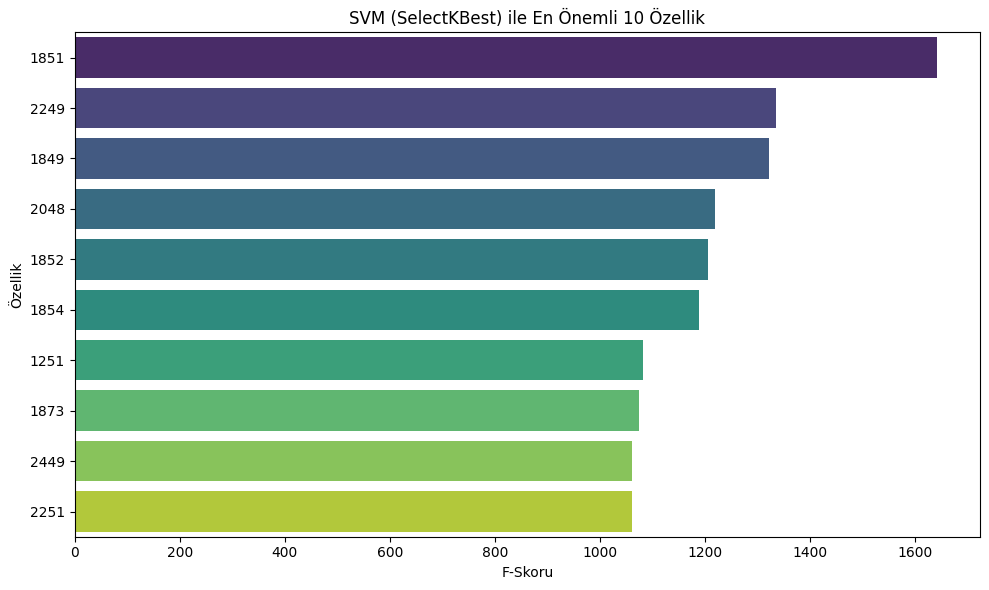

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
feature_selector = pipeline_touch_svm.named_steps['preprocessor'].named_steps['feature_selection']
scores = feature_selector.scores_
selected_indices = feature_selector.get_support(indices=True)
selected_feature_names = X_train_touch.columns[selected_indices]
selected_feature_scores = scores[selected_indices]
feature_scores_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Score': selected_feature_scores
}).sort_values(by='Score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores_df, x='Score', y='Feature', palette='viridis')
plt.title("SVM (SelectKBest) ile En Önemli 10 Özellik")
plt.xlabel("F-Skoru")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()


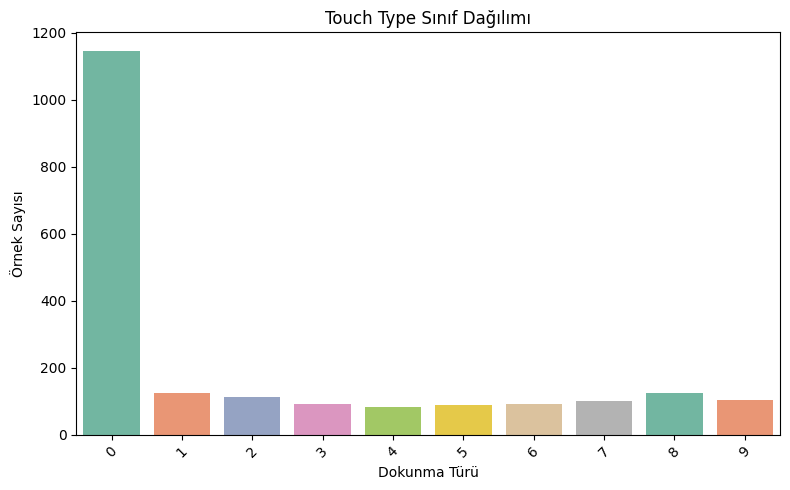

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='touch_type', palette='Set2')
plt.title("Touch Type Sınıf Dağılımı")
plt.xlabel("Dokunma Türü")
plt.ylabel("Örnek Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
